# Real and Fake Face detection
In this replository is a small application that uses a CNN to predict real or fake face.

Data has been collected from kaggle. For training ~1450 images and with an additional ~300 images for validation.

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense,MaxPool2D
import numpy as np
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

# Dataset

First let's load in the data I've collected from the program. I will use kera's ImageDataGenerator to not only label the data from the directories but also to slightly augment the data with shifts, rotations, zooms, and mirroring. Mirroring will help to ensure that the data are not biased to a particular handedness.

In [3]:
nbatch = 128
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('dataset/training',
                                                 target_size=(128,128),
                                                 batch_size =nbatch,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('dataset/test',
                                            target_size=(128,128),
                                            batch_size =nbatch,
                                            class_mode = 'binary')

Found 1437 images belonging to 2 classes.
Found 606 images belonging to 2 classes.


Text(0.5, 0, 'Class')

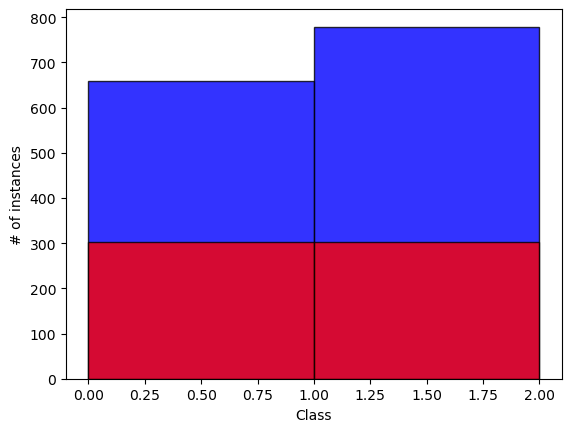

In [4]:
h1 = plt.hist(training_set.classes, bins=range(0,3), alpha=0.8, color='blue', edgecolor='black')
h2 = plt.hist(test_set.classes,  bins=range(0,3), alpha=0.8, color='red', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class')

(128, 128, 128, 3) (128,)


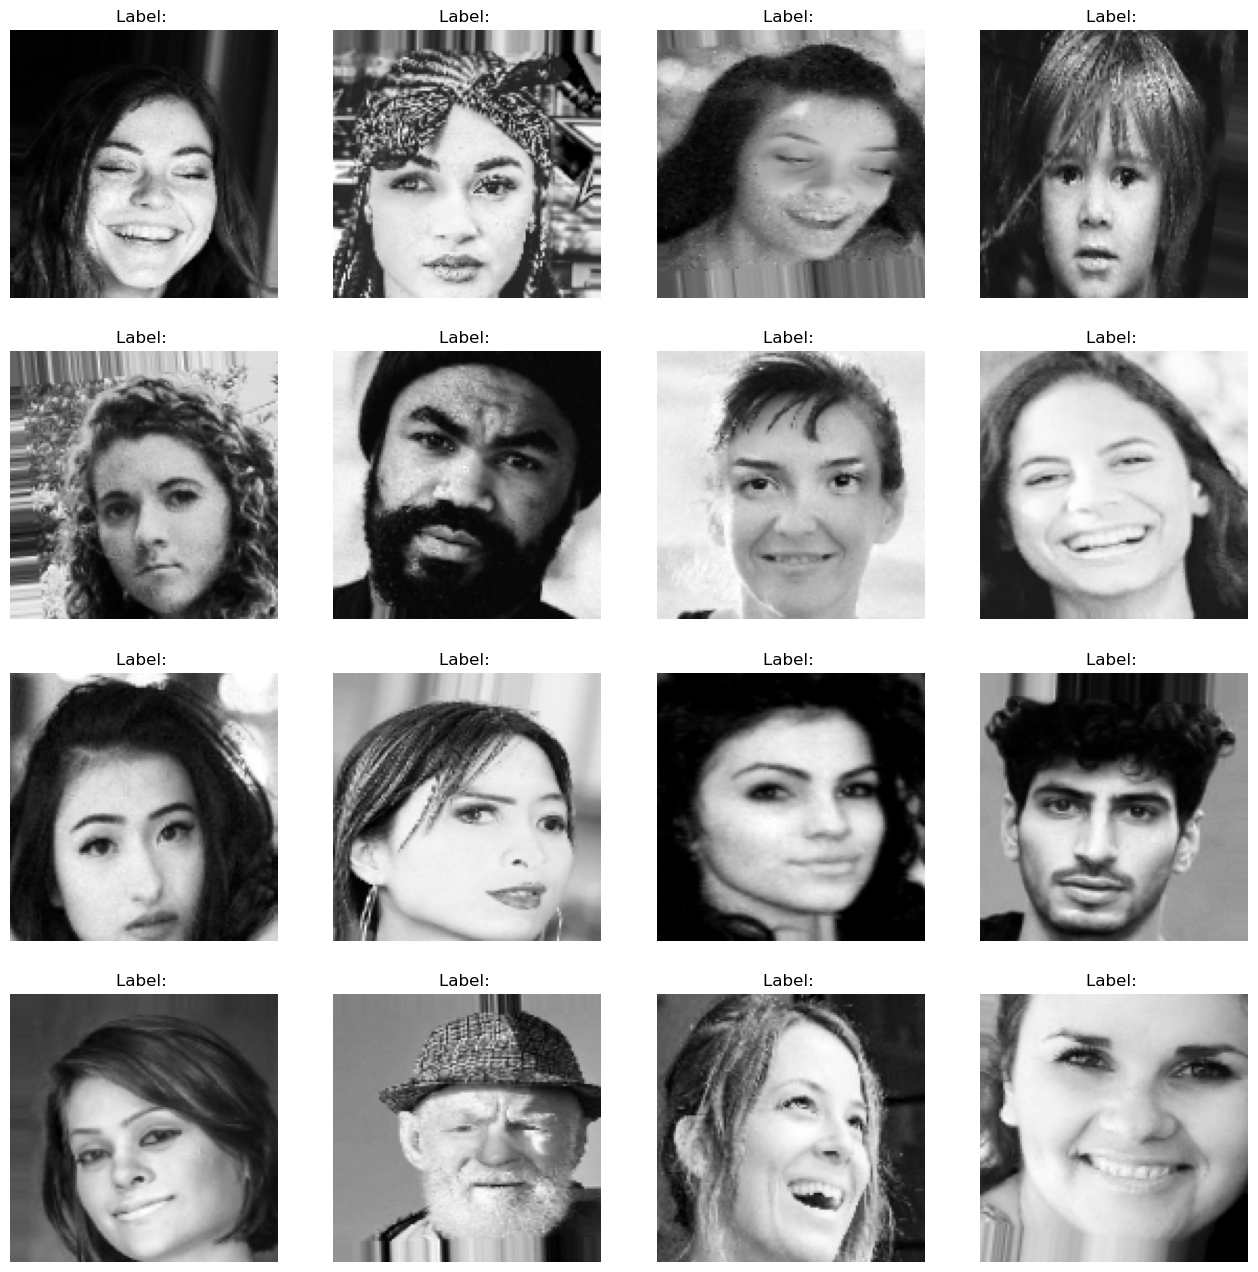

In [5]:
for X, y in training_set:
    print(X.shape, y.shape)
    plt.figure(figsize=(16,16))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.axis('off')
        plt.title('Label: ')
        img = np.uint8(255*X[i,:,:,0])
        plt.imshow(img, cmap='gray')
    break

# Convolutional Neural Net
The data looks resonable so now I will define a CNN model to train and use within our application.

In [6]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(128,128,3)))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(activation="relu",
                units=256))

model.add(Dense(activation="sigmoid",
                units=1))

model.summary()

C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,516,289 (24.86 MB)

 Trainable params: 6,516,289 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

##### Compile the model

In [7]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Training
Finally we will train our model using some keras helper functions. We are not doing any hyper-parameter optimization so we will not define a separate testing and validation set. We can however evaluate our model further in real time within the application.

In [8]:
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(filepath='model_checkpoint.keras', monitor='val_loss', save_best_only=True, mode='max'),
]


In [9]:
history = model.fit(
        training_set,
        steps_per_epoch=80,
        epochs=10,
        validation_data=test_set,
        validation_steps=28,
        callbacks = callbacks_list
    )

Epoch 1/10


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/80 ━━━━━━━━━━━━━━━━━━━━ 1:41 1s/step - accuracy: 0.5241 - loss: 0.8764

C:\Users\Dell\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


80/80 ━━━━━━━━━━━━━━━━━━━━ 53s 386ms/step - accuracy: 0.5305 - loss: 0.7487 - val_accuracy: 0.5330 - val_loss: 0.5774
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 47s 339ms/step - accuracy: 0.4979 - loss: 0.6479 - val_accuracy: 0.5000 - val_loss: 0.5782
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 47s 367ms/step - accuracy: 0.5438 - loss: 0.6459 - val_accuracy: 0.5000 - val_loss: 0.5788
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 50s 366ms/step - accuracy: 0.5441 - loss: 0.6458 - val_accuracy: 0.5000 - val_loss: 0.5794
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 47s 359ms/step - accuracy: 0.5438 - loss: 0.6449 - val_accuracy: 0.5000 - val_loss: 0.5783
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 48s 349ms/step - accuracy: 0.5419 - loss: 0.6437 - val_accuracy: 0.5000 - val_loss: 0.5802
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 47s 336ms/step - accuracy: 0.5408 - loss: 0.6443 - val_accuracy: 0.5000 - val_loss: 0.5789
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 48s 337ms/step - accuracy: 0.5431 - loss: 0.6449 - val_accuracy: 0.500

In [10]:
training_set.class_indices

{'fake': 0, 'real': 1}

Text(0.5, 0, '# of epochs')

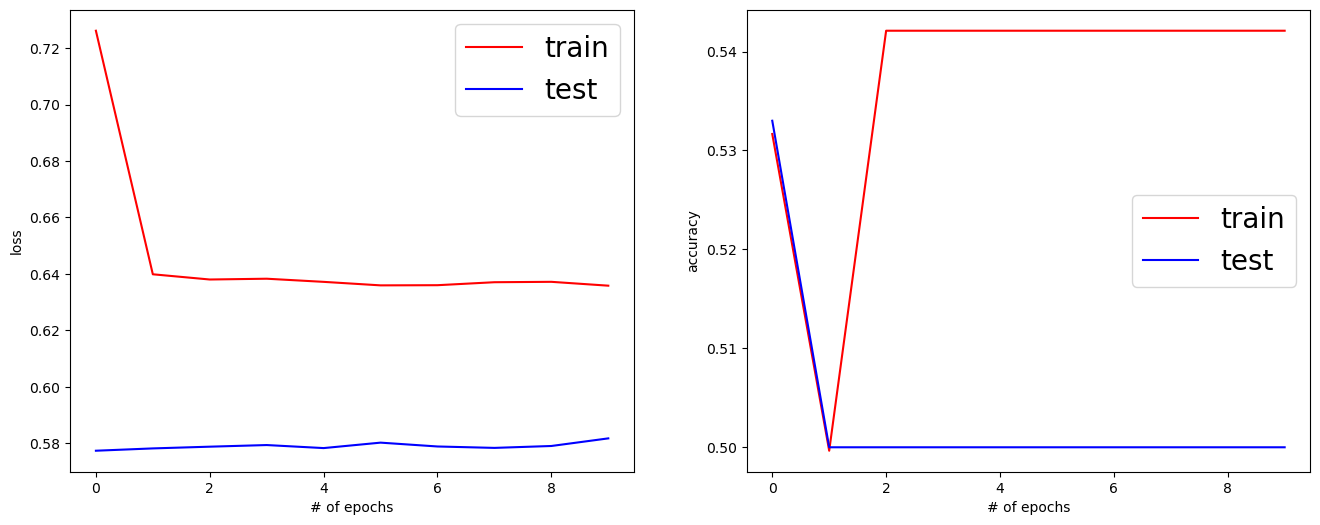

In [13]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
nepochs = len(history.history['loss'])
plt.plot(range(nepochs), history.history['loss'], 'r-', label='train')
plt.plot(range(nepochs), history.history['val_loss'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('loss')
plt.xlabel('# of epochs')
plt.subplot(1,2,2)
plt.plot(range(nepochs), history.history['accuracy'], 'r-', label='train')  # 'accuracy' instead of 'acc'
plt.plot(range(nepochs), history.history['val_accuracy'], 'b-', label='test')  # 'val_accuracy' instead of 'val_acc'
plt.legend(prop={'size': 20})
plt.ylabel('accuracy')
plt.xlabel('# of epochs')


In [12]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_set)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5127 - loss: 0.6942
Test Loss: 0.6976579427719116
Test Accuracy: 0.5


# Prediction
Now the model is trained so I used some real images and edited that image so that we can analysis model is working correcly or not.

In [13]:
def ImagePrediction(loc):
    test_image = image.load_img(loc, target_size = (128,128))
    plt.axis('off')
    plt.imshow(test_image)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis =0)
    result = model.predict(test_image)
    if result[0][0] == 1:
        predictions = 'Real'
    else:
        predictions = 'Fake'
    print('Prediction: ',predictions)

Enter Location of Image to predict:  dataset/face_pred/check.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
Prediction:  Real


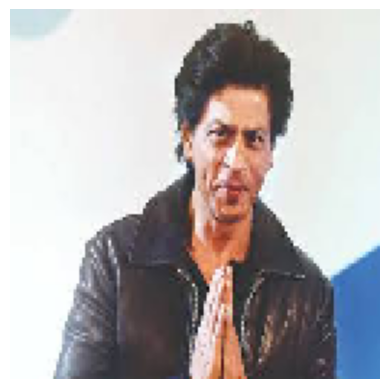

In [14]:
img = input("Enter Location of Image to predict: ")
test_image_1 = ImagePrediction(img)

Enter Location of Image to predict:  dataset/face_pred/check.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction:  Real


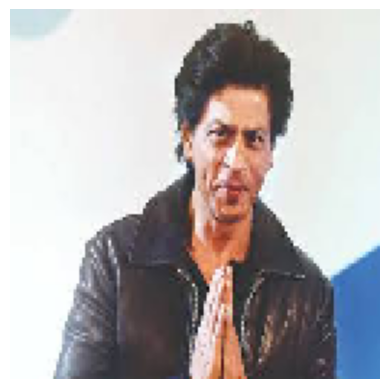

In [15]:
img = input("Enter Location of Image to predict: ")
test_image_2 = ImagePrediction(img)

Enter Location of Image to predict:  dataset/face_pred/check.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction:  Real


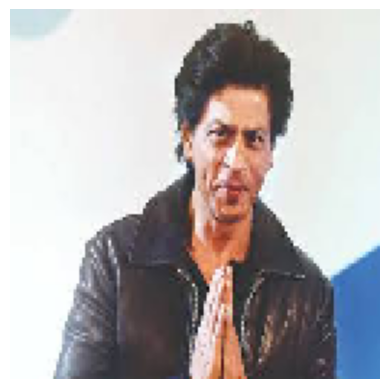

In [16]:
img = input("Enter Location of Image to predict: ")
test_image_3 = ImagePrediction(img)

Enter Location of Image to predict:  dataset/face_pred/check.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Prediction:  Fake


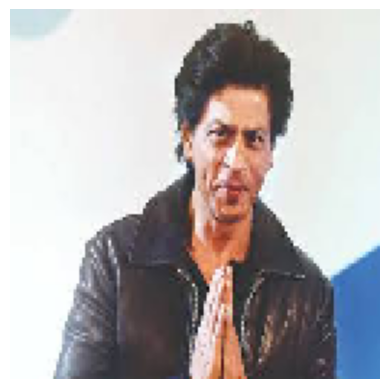

In [22]:
img = input("Enter Location of Image to predict: ")
test_image_3 = ImagePrediction(img)

## Result
3 out of 4 images is predicted correctly althrough model is not trained well by incereasing epoc near about 40 will probably make this model perfectly trained but that will require 5-6hr for training.

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the pre-trained VGG16 model without the top (classification) layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the pre-trained layers to prevent updating their weights during training
for layer in vgg16_base.layers:
    layer.trainable = False

# Create a new model and add the VGG16 base
model = Sequential()
model.add(vgg16_base)

# Flatten the output of the VGG16 base
model.add(Flatten())

# Add dense layers for classification
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Data augmentation and loading
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory('dataset/training',
                                                 target_size=(128, 128),
                                                 batch_size=128,
                                                 class_mode='binary')

test_set = test_datagen.flow_from_directory('dataset/test',
                                            target_size=(128, 128),
                                            batch_size=128,
                                            class_mode='binary')

# Training the model
history = model.fit(training_set,
                    steps_per_epoch=len(training_set),
                    epochs=10,
                    validation_data=test_set,
                    validation_steps=len(test_set))

# Model evaluation
model.evaluate(test_set)




Found 1437 images belonging to 2 classes.
Found 606 images belonging to 2 classes.
Epoch 1/10


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 122s 9s/step - accuracy: 0.5133 - loss: 1.4862 - val_accuracy: 0.5264 - val_loss: 0.6929
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10


C:\Users\Dell\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 117s 8s/step - accuracy: 0.5862 - loss: 0.6729 - val_accuracy: 0.6452 - val_loss: 0.6447
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 121s 9s/step - accuracy: 0.6405 - loss: 0.6370 - val_accuracy: 0.6403 - val_loss: 0.6464
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 122s 9s/step - accuracy: 0.6283 - loss: 0.6541 - val_accuracy: 0.5941 - val_loss: 0.6644
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 125s 9s/step - accuracy: 0.6051 - loss: 0.6569 - val_accuracy: 0.6683 - val_loss: 0.6181
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - l

[0.615880012512207, 0.6683168411254883]

In [19]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_set)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - accuracy: 0.6177 - loss: 0.6426
Test Loss: 0.6306463479995728
Test Accuracy: 0.6419141888618469


Enter Location of Image to predict:  dataset/face_pred/check2.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
Prediction:  Fake


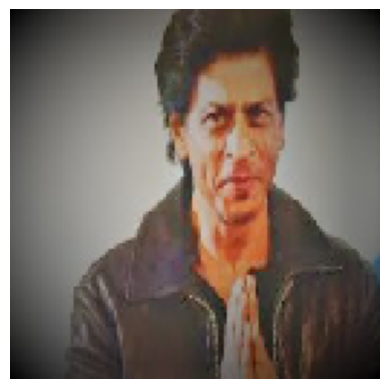

In [20]:
from keras.preprocessing import image 
import matplotlib.pyplot as plt
import numpy as np


def ImagePrediction(loc):
    test_image = image.load_img(loc, target_size = (128,128))
    plt.axis('off')
    plt.imshow(test_image)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis =0)
    result = model.predict(test_image)
    if result[0][0] == 1:
        predictions = 'Real'
    else:
        predictions = 'Fake'
    print('Prediction: ',predictions)

img = input("Enter Location of Image to predict: ")
test_image_1 = ImagePrediction(img)

5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step
              precision    recall  f1-score   support

        Real       0.47      0.49      0.48       303
        Fake       0.47      0.46      0.46       303

    accuracy                           0.47       606
   macro avg       0.47      0.47      0.47       606
weighted avg       0.47      0.47      0.47       606



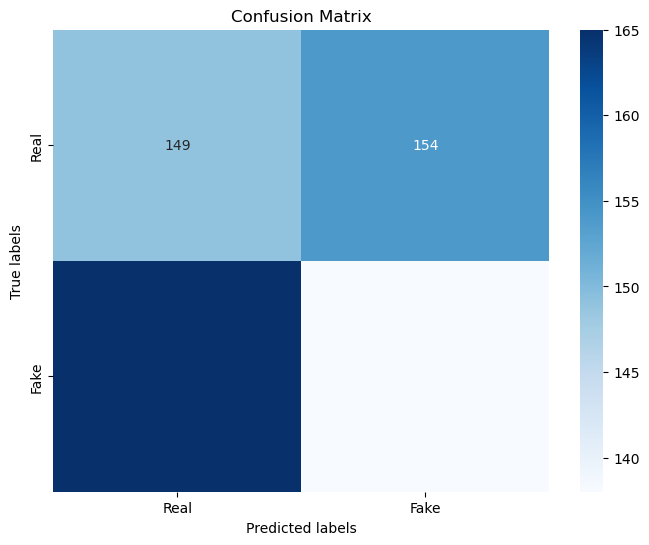

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Make predictions on the test set
y_pred = model.predict(test_set)
y_pred_binary = (y_pred > 0.5).astype(int)

# Get true labels
y_true = test_set.classes

# Print classification report
print(classification_report(y_true, y_pred_binary, target_names=["Real", "Fake"]))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
